In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import math
import re
import random
import csv

/home/ziyi/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# Network Parameters
num_input = 6
timesteps = 50 # timesteps
num_hidden = 100 # hidden layer num of features
num_output= 1

In [3]:
def read_sensor(filename):
    with open(filename, "r") as csvfile:
        reader = csv.reader(csvfile)
        dataset = [row[17:23] for row in reader]
        #data_x
        return np.array(dataset)
    
def read_xml(filename, length):
    f = open(filename)
    cts = f.read()
    f.close()

    p_foot = re.compile(r'<WhichFoot>(.*?)</WhichFoot>')
    all_foot = p_foot.findall(cts)

    p_time = re.compile(r'<Time>(.*?)</Time>')
    all_time = p_time.findall(cts)

    strike_times = []
    #L-1 R-0
    strike_times.append([0.0, 0.5])
    for i in range(len(all_foot)):
        if(all_foot[i]=='L'):
            strike_times.append([float(all_time[i]), 1])
        else:
            strike_times.append([float(all_time[i]), 0])
    strike_times[-1][1] = 0.5
    strike_times.append([length/25.0, 0.5])

    window_y = []
    strike_index=0
    for i in range(length):
        if(i/25.0 >= strike_times[strike_index+1][0]):
            strike_index += 1
        window_y.append([strike_times[strike_index][1]])

    p_info = re.compile(r'<StartTime>(.*?)</StartTime>\n\t<EndTime>(.*?)</EndTime>\n\t<NSteps>(.*?)</NSteps>\n\t<Direction>(.*?)</Direction>')
    all_info = p_info.findall(cts)#start_time, end_time, step_num, direction

    for i in range(len(all_info)):
        if(all_info[i][3][:4]=='Turn'):
#             print(all_info[i])
            start_time = int(float(all_info[i][0])*25)
            end_time = int(float(all_info[i][1])*25)
#             print('start and end time : ', all_info[i][0], all_info[i][1])
            for t in range(start_time-1, end_time):
                window_y[t] = [0.5]

#     print(len(window_y))  
    return window_y

def add_data(path, person, phone_location, assistant):
    data_x = read_sensor('weallwalk/sensor/iPhoneSensors_T'+str(path)+'_ID'+str(person)+'_'+phone_location+'_'+assistant+'.csv')
    data_y = read_xml('weallwalk/xml/T'+str(path)+'_ID'+str(person)+'_'+assistant+'.xml', len(data_x))
    
    split_x, split_x_part = [], []
    split_y, split_y_part = [], []
    for i in range(len(data_y)):
        if(data_y[i][0]!=0.5):
            split_y_part.append(data_y[i])
            split_x_part.append(data_x[i])
        else:
            if(len(split_y_part)>0):
                split_y.append(split_y_part)
                split_x.append(split_x_part)
                split_y_part = []
                split_x_part = []
    
    data_x_seq, data_y_seq = [], []
    for i in range(len(split_x)):
        data_x_part, data_y_part = [], []
        for j in range(len(split_x[i])-timesteps):
            x = split_x[i][j:j+timesteps]
            y = split_y[i][j+timesteps]
            data_x_part.append(x)
            data_y_part.append(y)
        if(len(data_x_part)>0):
            data_x_seq.append(data_x_part)
            data_y_seq.append(data_y_part)
    
    return data_x_seq, data_y_seq

In [4]:
step_data_list = []
for i in range(1,6):
    step_data_list.append([i, 11, '1L', 'NA'])
    step_data_list.append([i, 12, '1L', 'NA'])
    step_data_list.append([i, 13, '1L', 'NA'])
    step_data_list.append([i, 14, '1L', 'NA'])
    step_data_list.append([i, 15, '1L', 'NA'])
    step_data_list.append([i, 11, '2R', 'NA'])
    step_data_list.append([i, 12, '2R', 'NA'])
    step_data_list.append([i, 13, '2R', 'NA'])
    step_data_list.append([i, 14, '2R', 'NA'])
    step_data_list.append([i, 15, '2R', 'NA'])    
    
print(step_data_list)

[[1, 11, '1L', 'NA'], [1, 12, '1L', 'NA'], [1, 13, '1L', 'NA'], [1, 14, '1L', 'NA'], [1, 15, '1L', 'NA'], [1, 11, '2R', 'NA'], [1, 12, '2R', 'NA'], [1, 13, '2R', 'NA'], [1, 14, '2R', 'NA'], [1, 15, '2R', 'NA'], [2, 11, '1L', 'NA'], [2, 12, '1L', 'NA'], [2, 13, '1L', 'NA'], [2, 14, '1L', 'NA'], [2, 15, '1L', 'NA'], [2, 11, '2R', 'NA'], [2, 12, '2R', 'NA'], [2, 13, '2R', 'NA'], [2, 14, '2R', 'NA'], [2, 15, '2R', 'NA'], [3, 11, '1L', 'NA'], [3, 12, '1L', 'NA'], [3, 13, '1L', 'NA'], [3, 14, '1L', 'NA'], [3, 15, '1L', 'NA'], [3, 11, '2R', 'NA'], [3, 12, '2R', 'NA'], [3, 13, '2R', 'NA'], [3, 14, '2R', 'NA'], [3, 15, '2R', 'NA'], [4, 11, '1L', 'NA'], [4, 12, '1L', 'NA'], [4, 13, '1L', 'NA'], [4, 14, '1L', 'NA'], [4, 15, '1L', 'NA'], [4, 11, '2R', 'NA'], [4, 12, '2R', 'NA'], [4, 13, '2R', 'NA'], [4, 14, '2R', 'NA'], [4, 15, '2R', 'NA'], [5, 11, '1L', 'NA'], [5, 12, '1L', 'NA'], [5, 13, '1L', 'NA'], [5, 14, '1L', 'NA'], [5, 15, '1L', 'NA'], [5, 11, '2R', 'NA'], [5, 12, '2R', 'NA'], [5, 13, '2R'

In [5]:
data_x, data_y = [], []
for i in step_data_list:
    data_x_segement, data_y_segement = add_data(i[0], i[1], i[2], i[3])
    for dx in data_x_segement:
        data_x.extend(dx)
    for dy in data_y_segement:
        data_y.extend(dy)
    
print(len(data_x))
print(len(data_y))

108307
108307


In [6]:
data_size = len(data_x)
batch_size = 256
print(data_size)

order = list(range(0,len(data_x),1))
random.shuffle(order)

train_x_list, train_y_list = [], []
valid_x_list, valid_y_list = [], []

#10 fold cross validation
for i in range(0,10):
    start = int(data_size*1.0/10*i)
    end = int(data_size*1.0/10*(i+1))
    print(start, end)
    
    train_x = [data_x[i] for i in order[0:start]]
    train_x.extend([data_x[i] for i in order[end:data_size]])
    train_x.extend([train_x[i] for i in range(0, batch_size)])
    train_y = [data_y[i] for i in order[0:start]]
    train_y.extend([data_y[i] for i in order[end:data_size]])
    train_y.extend([train_y[i] for i in range(0, batch_size)])
    train_x_list.append(train_x)
    train_y_list.append(train_y)
    
    valid_x = [data_x[i] for i in order[start:end]]
    valid_x.extend([valid_x[i] for i in range(0, batch_size)])
    valid_y = [data_y[i] for i in order[start:end]]
    valid_y.extend([valid_y[i] for i in range(0, batch_size)])
    valid_x_list.append(valid_x)
    valid_y_list.append(valid_y)
    
    print(len(train_x), len(valid_x))

108307
0 10830
97733 11086
10830 21661
97732 11087
21661 32492
97732 11087
32492 43322
97733 11086
43322 54153
97732 11087
54153 64984
97732 11087
64984 75814
97733 11086
75814 86645
97732 11087
86645 97476
97732 11087
97476 108307
97732 11087


In [7]:
step_test_list = []
for i in range(6,7):
    step_test_list.append([i, 11, '1L', 'NA'])
    step_test_list.append([i, 12, '1L', 'NA'])
    step_test_list.append([i, 13, '1L', 'NA'])
    step_test_list.append([i, 14, '1L', 'NA'])
    step_test_list.append([i, 15, '1L', 'NA'])
    step_test_list.append([i, 11, '2R', 'NA'])
    step_test_list.append([i, 12, '2R', 'NA'])
    step_test_list.append([i, 13, '2R', 'NA'])
    step_test_list.append([i, 14, '2R', 'NA'])
    step_test_list.append([i, 15, '2R', 'NA'])    
        
print(step_test_list)

[[6, 11, '1L', 'NA'], [6, 12, '1L', 'NA'], [6, 13, '1L', 'NA'], [6, 14, '1L', 'NA'], [6, 15, '1L', 'NA'], [6, 11, '2R', 'NA'], [6, 12, '2R', 'NA'], [6, 13, '2R', 'NA'], [6, 14, '2R', 'NA'], [6, 15, '2R', 'NA']]


In [8]:
test_x, test_y=[], []
for i in step_test_list:
    data_x_segement, data_y_segement = add_data(i[0], i[1], i[2], i[3])
    test_x.extend(data_x_segement)
    test_y.extend(data_y_segement)
#     test_x.append(data_x_segement)
#     test_y.append(data_y_segement)
    
print(len(test_x))
print(len(test_y))

print([len(i) for i in test_y])

32
32
[10, 489, 1035, 51, 424, 884, 25, 535, 1057, 686, 598, 1184, 821, 604, 1141, 774, 10, 489, 1035, 51, 424, 884, 25, 535, 1057, 686, 598, 1184, 821, 604, 1141, 774]


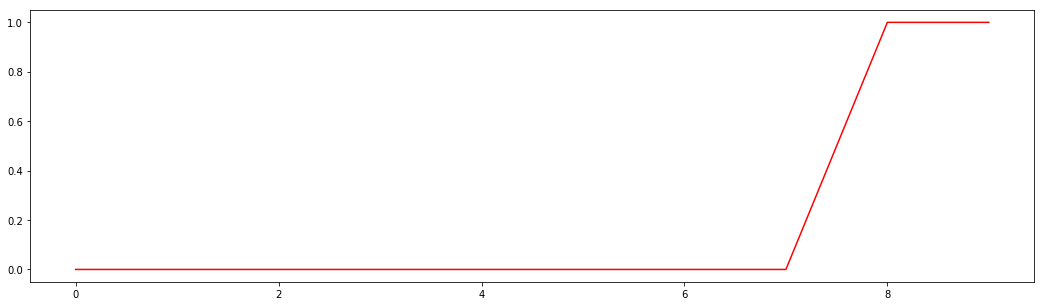

In [9]:
plt.figure(figsize=(18, 5))
plt.plot([i[0] for i in test_y[0]], 'r')
plt.show()

In [10]:
NUM_LAYERS=2

def LstmCell():
    lstm_cell = tf.contrib.rnn.BasicLSTMCell(num_hidden)#, forget_bias=1.0)
    cell = tf.contrib.rnn.DropoutWrapper(lstm_cell, output_keep_prob=0.5)
    return cell

graph = tf.Graph()
with graph.as_default(), tf.device('/gpu:0'):
    # tf Graph input
    X = tf.placeholder("float", [None, timesteps, num_input])
    Y = tf.placeholder("float", [None, num_output])
    
    # Define weights
    weights = {
        'out': tf.Variable(tf.random_normal([num_hidden, num_output]))
    }
    biases = {
        'out': tf.Variable(tf.random_normal([num_output]))
    }
    
    def RNN(x, weights, biases):
        x = tf.unstack(x, timesteps, 1)
        cell = tf.contrib.rnn.MultiRNNCell([LstmCell() for _ in range(NUM_LAYERS)])
        outputs, state = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
        outputs = tf.transpose(outputs, [1,0,2])

        return tf.matmul(outputs[-1], weights['out']) + biases['out']
    

    logits = RNN(X, weights, biases)
    mean_train = tf.reduce_mean(X)
    loss = tf.reduce_mean(tf.squared_difference(logits, Y))

    optimizer = tf.train.AdamOptimizer(learning_rate = 0.001).minimize(loss)
    
    saver = tf.train.Saver()

In [11]:
batch_size = 256
batch_start = 0;
train_length = len(train_x)
print(train_length)

train_x_extend = [i for i in train_x]
train_y_extend = [i for i in train_y]

print(len(train_x_extend))

97732
97732


In [12]:
if(len(train_x_extend)==len(train_x)):
    train_x_extend.extend(train_x[0:batch_size])
    train_y_extend.extend(train_y[0:batch_size])
print(len(train_x_extend))

97988


In [13]:
def cal_accuarcy(y, _y):
    count = 0
    for i in range(0, len(y)):
        if(y[i][0] == round(_y[i][0])):
            count += 1;
    return count*1.0/len(y)
#     print("train accuarcy : ", count/len(y))

In [28]:
def test_accuarcy(test_y, test_logits):
    test_logits_int = [[round(i[0])] for i in test_logits]

    count = 0
    for i in range(0, len(test_y)):
        if(test_y[i][0] == test_logits_int[i][0]):
            count += 1;
    print("test accuarcy : ", count*1.0/len(test_y))

In [29]:
training_steps = 1001

for i in range(0, 10):
    print("cross validation ", i)
    batch_start = 0
    train_x = train_x_list[i]
    train_y = train_y_list[i]
    config = tf.ConfigProto(allow_soft_placement=True)
    with tf.Session(graph=graph, config=config) as session:
#         saver.restore(session, tf.train.latest_checkpoint('lstm_check'))
    #     saver.restore(session, "lstm_check/my-model-gpu-error-metric-dropout2.ckpt-6000")
        tf.global_variables_initializer().run()
        print('Initialized')
        for step in range(training_steps):      
            feed_dict = {X: train_x[batch_start:batch_start+batch_size], Y: train_y[batch_start:batch_start+batch_size]}
            _, l, predictions, m = session.run([optimizer, loss, logits, mean_train], feed_dict = feed_dict)
            if (step % 200 == 0):
                train_accuarcy = cal_accuarcy(train_y[batch_start:batch_start+batch_size], predictions)
                print('Loss at step %d: %f, train accuarcy : %f' % (step, l, train_accuarcy))
                #train accuarcy
            if (step % 1000 == 0):
                saver.save(session, 'lstm_check/my-model-gpu-error-metric-dropout2-na-10fold-'+str(i)+'-.ckpt', global_step=step+6000)
            batch_start += batch_size
            if(batch_start>=train_length):
                batch_start -=train_length
        valid_loss, valid_logits = session.run([loss,logits], feed_dict={X: valid_x_list[i], Y: valid_y_list[i]})
        print("test loss : ", valid_loss)
        test_accuarcy(valid_y_list[i], valid_logits)

#     test_loss, test_logits = [], []
#     for i in range(len(test_x)):
#         test_loss_part, test_logits_part = session.run([loss,logits], feed_dict={X: test_x[i], Y: test_y[i]})
#         test_loss.append(test_loss_part)
#         test_logits.append(test_logits_part)

cross validation  0
Initialized
Loss at step 0: 0.800295, train accuarcy : 0.414062
Loss at step 200: 0.104513, train accuarcy : 0.882812
Loss at step 400: 0.085948, train accuarcy : 0.914062
Loss at step 600: 0.086683, train accuarcy : 0.902344
Loss at step 800: 0.091673, train accuarcy : 0.886719
Loss at step 1000: 0.077218, train accuarcy : 0.917969
test loss :  0.0754572
test accuarcy :  0.9182753021829334
cross validation  1
Initialized
Loss at step 0: 1.054905, train accuarcy : 0.320312
Loss at step 200: 0.107571, train accuarcy : 0.886719
Loss at step 400: 0.086489, train accuarcy : 0.933594
Loss at step 600: 0.092603, train accuarcy : 0.886719
Loss at step 800: 0.082522, train accuarcy : 0.910156
Loss at step 1000: 0.074034, train accuarcy : 0.929688
test loss :  0.0768431
test accuarcy :  0.914404257238207
cross validation  2
Initialized
Loss at step 0: 0.853357, train accuarcy : 0.457031
Loss at step 200: 0.109510, train accuarcy : 0.898438
Loss at step 400: 0.096257, train a

In [32]:
with tf.Session(graph=graph, config=config) as session:
    saver.restore(session, "lstm_check/my-model-gpu-error-metric-dropout2-na-10fold-9-.ckpt-7000")
    print('Test')

    test_loss, test_logits = [], []
    for i in range(len(test_x)):
        test_loss_part, test_logits_part = session.run([loss,logits], feed_dict={X: test_x[i], Y: test_y[i]})
        test_loss.append(test_loss_part)
        test_logits.append(test_logits_part)

INFO:tensorflow:Restoring parameters from lstm_check/my-model-gpu-error-metric-dropout2-na-10fold-9-.ckpt-7000
Test


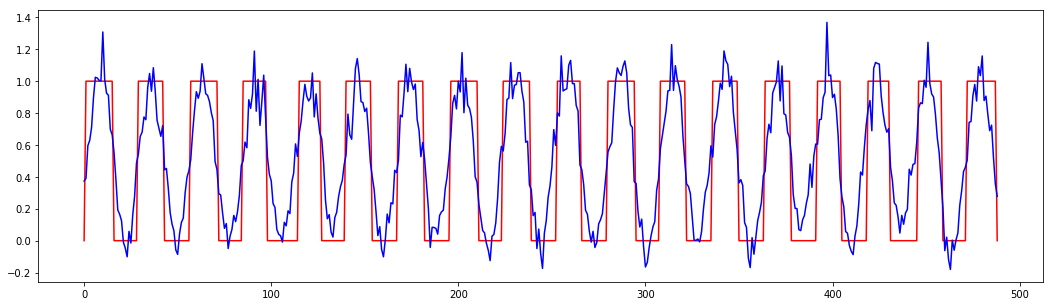

In [34]:
plt.figure(figsize=(18, 5))
start=0
end=2000
plt.plot([i[0] for i in test_y[1][start:end]], 'r')
plt.plot([i[0] for i in test_logits[1][start:end]], 'b')
plt.show()

In [35]:
print("test loss : ", test_loss)

test loss :  [0.24231574, 0.071910828, 0.069637224, 0.065587156, 0.094165862, 0.094201542, 0.19963633, 0.087144025, 0.082992822, 0.085845523, 0.061695799, 0.069226727, 0.073593833, 0.10366201, 0.10007786, 0.10881026, 0.025639361, 0.05771862, 0.062023085, 0.07864698, 0.095371261, 0.096060775, 0.17542538, 0.071105532, 0.063449949, 0.059803303, 0.068947174, 0.074991085, 0.071698934, 0.085482366, 0.085745968, 0.10134447]


In [36]:
test_logits_bin = []
for t in test_logits:
    test_logits_part = [[round(i[0])] for i in t]
    for i in range(1, len(test_logits_part)-1):
        if(test_logits_part[i-1][0]!=test_logits_part[i][0] and test_logits_part[i-1][0]==test_logits_part[i+1][0]):
            test_logits_part[i][0]=test_logits_part[i-1][0]    
    test_logits_bin.append(test_logits_part)

count = 0
total = 0
for i in range(0, len(test_x)):
    total += len(test_y[i])
    for j in range(0, len(test_y[i])):
        if(test_y[i][j][0] == test_logits_bin[i][j][0]):
            count += 1

print(count)
print(total)
print("test accuarcy : ", count*1.0/total)

18629
20636
test accuarcy :  0.9027427796084513


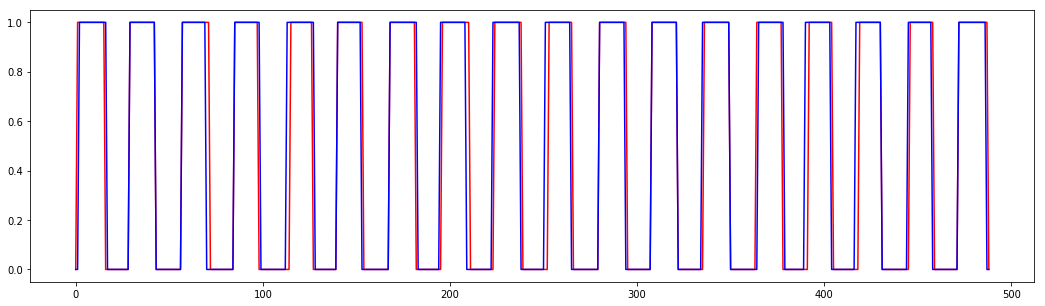

In [40]:
plt.figure(figsize=(18, 5))
start=0
end=2000
plt.plot([i[0] for i in test_y[1][start:end]], 'r')
plt.plot([i[0] for i in test_logits_bin[1][start:end]], 'b')
plt.show()

In [41]:
step_time_actual, step_time_predict= [], []

for i in range(0, len(test_x)):
    step_time_actual_part, step_time_predict_part= [], []
    for j in range(0, len(test_y[i])-1):
        if(abs(test_y[i][j][0]-test_y[i][j-1][0])>0.5):
            step_time_actual_part.append(j)
    #     if(abs(test_logits[i][0]-test_logits[i-1][0])>0.5):
        if(abs(test_logits_bin[i][j][0]-test_logits_bin[i][j-1][0])>0.5):
            step_time_predict_part.append(j)
    step_time_actual.append(step_time_actual_part)
    step_time_predict.append(step_time_predict_part)

print('Step number for each segement')
print([len(i) for i in step_time_actual])   
print([len(i) for i in step_time_predict])

Step number for each segement
[2, 35, 74, 4, 30, 64, 2, 36, 71, 46, 42, 82, 58, 40, 78, 54, 2, 35, 74, 4, 30, 64, 2, 36, 71, 46, 42, 82, 58, 40, 78, 54]
[2, 36, 75, 3, 30, 64, 2, 36, 71, 46, 42, 82, 58, 40, 80, 56, 2, 36, 76, 4, 30, 64, 2, 36, 71, 46, 42, 82, 58, 40, 78, 56]


In [42]:
total_step_count = sum([len(i) for i in step_time_actual])
metric1_undercount = 0
metric2_undercount = 0
metric1_overcount = 0
metric2_overcount = 0

for i in range(len(test_x)):
    step_count = len(step_time_actual[i])
    undercount = 0
    overcount = 0

    for j in range(1, step_count):
        gap_count = [t for t in step_time_predict[i] if t>=step_time_actual[i][j-1] and t<step_time_actual[i][j]]
    #     print(gap_count)
        if(len(gap_count)>1):
            overcount += len(gap_count)-1
        if(len(gap_count)<1):
            undercount += 1
    
    metric1_undercount += undercount
    metric1_overcount += overcount
#     print(undercount, overcount)
#     print('undercount : ', undercount*1.0/step_count)
#     print('overcount : ', overcount*1.0/step_count)
    diff = len(step_time_predict[i])-len(step_time_actual[i])
#     if(diff==0):
#         print("segement correct!")

    if(diff<0):
#         print('segement undercount : ', 1-len(step_time_predict[i])*1.0/len(step_time_actual[i]))
        metric2_undercount -= diff
    if(diff>0):
#         print('segement overcount : ', 1-len(step_time_actual[i])*1.0/len(step_time_predict[i]))
        metric2_overcount += diff

print('error : ')
print("total undercount metric 1 : ", metric1_undercount*1.0/total_step_count)
print("total overcount metric 1 : ", metric1_overcount*1.0/total_step_count)
print("total undercount metric 2 : ", metric2_undercount*1.0/total_step_count)
print("total overcount metric 2 : ", metric2_overcount*1.0/total_step_count)

error : 
total undercount metric 1 :  0.17548746518105848
total overcount metric 1 :  0.1775766016713092
total undercount metric 2 :  0.0006963788300835655
total overcount metric 2 :  0.00766016713091922
